In [13]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from numpy import array
from tqdm import tqdm
import pandas as pd
import jieba
import jieba.analyse
import jieba.posseg
import numpy as np
import gensim
from gensim import corpora, models, similarities
import logging
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use({'figure.figsize':(12, 12)}) # 画布大小
sns.set_style('whitegrid')  # 风格样式
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常

import NLP
user_document=pd.read_csv(f"{NLP.data_path}user_document.csv", encoding='utf_8_sig' )


# token
# 去除TF较高和较低的词
(没有特别意义的词)

In [14]:
# 创建停用词列表
def stopwordslist():
    stopwords = [line.strip() for line in open('stop_words.txt', encoding='UTF-8').readlines()]
    return stopwords
# 对句子进行中文分词
def seg_depart(sentence):
    # 对文档中的每一行进行中文分词
    sentence_depart = jieba.cut(sentence.strip())
    outstr = ''
    # 去停用词
    for word in sentence_depart:
        if word not in stopwords:
            if word != '\t':
                outstr += word
                outstr += " "
    return outstr
# 创建一个停用词列表
stopwords = stopwordslist()
for key in ['手机','推荐','不错','贴水', '感觉','真的','沸腾']:
    stopwords.append(key)

In [15]:
user_document['token']=None
for index,row in tqdm(user_document.iterrows()):
    line_seg = seg_depart(row['sentence'])
    user_document.at[index,'token']=line_seg

30803it [00:13, 2205.62it/s]


In [16]:
print(user_document[user_document['token'].str.contains('手机')]['token'].shape)

(335,)


# ~~以每一句输入作为文档~~ 短文本不适合
# 以每个人的所有评论作为输入

In [17]:
print('2.开始读入语料数据 ------ ')
from tqdm import tqdm
user_all_comment=pd.DataFrame(columns=['author_user_name','docs','token'])
for name,group in tqdm(user_document.groupby('author_user_name')):
    index=user_all_comment.shape[0]
    user_all_comment.at[index,'author_user_name']=name
    user_all_comment.at[index,'docs']=group['sentence'].tolist()
    result=[]
    for cell in group['token'].tolist():
        result.extend(cell.split(' '))
    user_all_comment.at[index,'token']= result
    # break

100%|██████████| 16186/16186 [00:11<00:00, 1389.76it/s]


2.开始读入语料数据 ------ 


In [18]:
user_all_comment.to_csv(f'user_all_comment.csv', encoding='utf_8_sig', index=False)

In [19]:
docs=user_all_comment['token'].tolist()

In [20]:
# Tokenize the documents.
from nltk.tokenize import RegexpTokenizer
# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]
# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in docs]
print(f'有{len(docs)}个文档')

# 建立字典
dictionary = corpora.Dictionary(docs)
# 转换文本数据为索引，并计数 ,做映射 相当于词袋
corpus = [dictionary.doc2bow(text) for text in docs]


有16186个文档


# 做不同人群的LDA
# 挑选一个最大的值

C:\Users\16691\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 29/29 [02:40<00:00,  5.52s/it]


[-2.621253799475166, -2.8041724224294526, -3.1267178363215926, -3.2344833742377226, -3.571245722745958, -5.241652367871958, -4.238077077781596, -5.380511357343918, -5.753521370465232, -5.455144395159382, -5.134695157494592, -5.252596298906858, -6.226316516423325, -5.612208390778025, -6.715244994737014, -6.5869888830342225, -6.332364798552537, -6.48559165819925, -6.760715842162811, -7.018166524213129, -6.719389495191133, -7.263360142686434, -7.459388635669797, -6.628645509851869, -7.31559823151191, -7.746296415702005, -7.360805180016971, -7.463862951979533, -7.530562038417711]


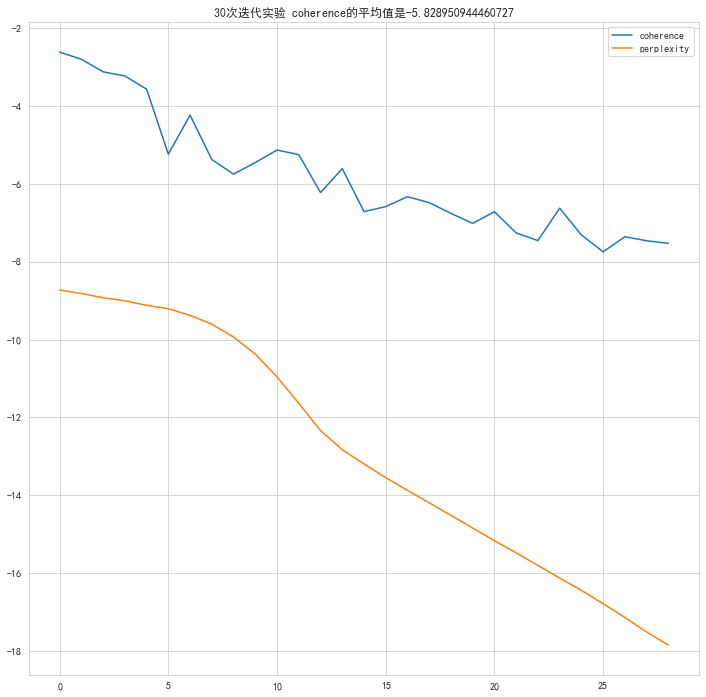

In [31]:
from tqdm import tqdm
import numpy as np
iterations=1000

def lda_diff_people(corpus,dictionary,test_iterations):
    '''

    :param corpus:
    :param dictionary:
    :param test_iterations: 控制实验迭代次数
    :return:
    '''
    coherence=[]
    perplexity=[]
    for i in tqdm(range(1,test_iterations)):
        # print(f'主题个数为{i}个')
        num_topics=i
        lda= gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=dictionary,num_topics=num_topics,iterations=iterations)
        perplexity.append( lda.log_perplexity(corpus))
        lda_cm= CoherenceModel(model=lda, corpus=corpus, dictionary=dictionary, coherence='u_mass')
        coherence.append(lda_cm.get_coherence())

    print(coherence)
    plt.plot(range(len(coherence)),coherence,label='coherence')
    plt.plot(range(len(perplexity)),perplexity,label='perplexity')
    plt.title(f'{test_iterations}次迭代实验 coherence的平均值是{np.mean(coherence)}')
    plt.legend()
    # plt.savefig(f'{info_path}lda_comment.png')
    plt.savefig(f'lda_comment.png')
    plt.show()
    return coherence

tmp=lda_diff_people(corpus,dictionary,30)

In [11]:
# print(dictionary['token2id']['手机'])

KeyError: 'token2id'

In [36]:
topic_num=10
info_path='./data/'
lda= gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=dictionary,num_topics=topic_num,iterations=iterations)
lda.save(f'{info_path}lda_one_document_model')
lda.save(f'{info_path}lda_model')
# lda = LdaModel.load(f'{info_path}lda_one_document_model')

C:\Users\16691\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
import pyLDAvis.gensim

topic_num=10
lda= gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=dictionary,num_topics=topic_num,iterations=iterations)
lda_visual=pyLDAvis.gensim.prepare(lda, corpus, dictionary)
pyLDAvis.show(lda_visual)
pyLDAvis.save_html(lda_visual,f'pyLDAvis_{topic_num}.html')
# pyLDAvis.save_json(lda_visual,f'pyLDAvis_{topic_num}.json')


C:\Users\16691\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
127.0.0.1 - - [05/Jan/2021 10:56:07] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [05/Jan/2021 10:56:07] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [05/Jan/2021 10:56:07] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [05/Jan/2021 10:56:07] "GET /LDAvis.js HTTP/1.1" 200 -



Note: if you're in the IPython notebook, pyLDAvis.show() is not the best command
      to use. Consider using pyLDAvis.display(), or pyLDAvis.enable_notebook().
      See more information at http://pyLDAvis.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8889/    [Ctrl-C to exit]

stopping Server...


In [37]:
for i in range(topic_num):
    user_all_comment[f'topic{i}_prob']=None
for index,row in tqdm(user_all_comment.iterrows()):
    # test_corpus = [dictionary.doc2bow(text) for text in row['token']]
    test_corpus = dictionary.doc2bow(row['token'])
    vector = lda[test_corpus]
    for category,prob in vector:
        user_all_comment.at[index,f'topic{category}_prob']=prob
    # if index==5:
    #     break

C:\Users\16691\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
16186it [00:05, 3156.61it/s]


# 主题关键词为graphsage 的特征

In [38]:
import re
import json
key_word=[]
for topic in lda.print_topics(num_words=50):
    print(topic[0])
    # print(re.findall('"(.*?)"',topic[1]))
    key_word.extend(re.findall('"(.*?)"',topic[1]))
key_word=list(set(key_word))
print(key_word)
print(len(key_word))
with open('words_feature.json', 'w', encoding='utf8')as fp:
    json.dump(key_word, fp, ensure_ascii=False)


0
1
2
3
4
5
6
7
8
9
['数据', '厉害', '9x', '高通', '壳子', 'app', '轻薄', '广告', '下降', '玩游戏', '5G', '定位', '同事', '贾跃亭', '分享', '性价比', '3g', '我用', '镜头', '流畅', '上次', '断流', '现实', '一块', '诺基亚', '唯一', '价格', '卧槽', '大厂', '选择', '竞争力', '支持', '价钱', 'S10', '重度', '去年', 'v10', '两年', '错误', '刘海', '友们', '前排', '垃圾', '大佬', '稳定版', '信号', '失灵', '电池', '声音', '模式', '截屏', '不卡', '山寨', '帖子', '你好', '哪款', '哥哥', '服务', '下巴', '英雄', '无线', '3.5', '带来', '日常', '打游戏', '农药', '不好意思', '打开', '按键', '掉电', '相比', '设置', '说话', '反馈', '评测', 'note10', '曲面', '软件', '连续', '猴子', '不到', '质量', '产品', '算了吧', '品牌', '超大', '真实', '全网', '颜值', '魅族', '发货', '官方', '骁龙', '充电', '晚上', '平时', 'xs', 'MX3', '优化', '稳定', '全家', '难受', '拿来', '设计', 'note9', '运营商', '有图', '为啥', '面前', '清理', '线上', '告诉', '电脑', '白色', '就行', '消息', '勉强', '看不到', '早就', '提供', '媒体', '玩玩', '买手机', '一点', '型号', '听说', '小时', '技术', '买个', '分钟', '成熟', '几天', '亮度', 'lcd', '耐用', 'nova', '砖头', '系统', '系列', '有钱', '楼主', '显示屏', '网页', '青春', '恶心', '退回', '屏下', '不用', '分辨率', 'iQOO', '节奏', '没电', '还行', '预售', '智商', '效果', '关注', '高配',

C:\Users\16691\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
user_all_comment.fillna('0',inplace=True)
user_all_comment[[i for i in user_all_comment.columns if i not in ['token']]].to_csv(f'user_topic_prob.csv', encoding='utf_8_sig', index=False)



C:\Users\16691\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
